In [1]:
import numpy as np 
import pandas as pd  
import torch
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 
import torch.nn.functional as F 

data_dir = './data'

In [2]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader 
from torchvision import transforms as T,datasets  
from torchvision.models import resnet50 , mobilenet_v2

In [3]:
class CNFG:
    epochs =20                             
    lr = 0.001                             
    batch_size = 256              
    img_size = 224
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:{}".format(device))

Device:cpu


In [4]:
data_transform = T.Compose([
                             T.Resize(size=(CNFG.img_size,CNFG.img_size)), # Resizing the image to be 224 by 224
                            #  T.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                            #  T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels
                            
])

In [5]:
data = datasets.ImageFolder(data_dir,       
                    transform=data_transform)
total_count = len(data) 
total_count

159

In [6]:
train_count = int(0.7 * total_count) 
valid_count = int(0.2 * total_count)
test_count = total_count - train_count - valid_count
train_data, val_data, test_data = torch.utils.data.random_split(data, (train_count, valid_count, test_count))  
print("Train data: {} images".format(len(train_data))) 
print("Validation data: {} images".format(len(val_data))) 
print("Test data: {} images".format(len(test_data)))

Train data: 111 images
Validation data: 31 images
Test data: 17 images


In [7]:
def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [8]:
train_data.dataset.classes

['chinese', 'italian', 'japanese', 'spanish']

In [9]:
train_data

In [10]:
trainloader = DataLoader(train_data,batch_size=CNFG.batch_size,shuffle=True)
print("No. of batches in trainloader:{}".format(len(trainloader))) 
print("No. of Total examples:{}".format(len(trainloader.dataset)))

validationloader = DataLoader(val_data,batch_size=CNFG.batch_size,shuffle=True)
print("No. of batches in validationloader:{}".format(len(validationloader)))  
print("No. of Total examples:{}".format(len(validationloader.dataset)))

testloader = DataLoader(test_data,batch_size=CNFG.batch_size,shuffle=True)
print("No. of batches in testloader:{}".format(len(testloader))) 
print("No. of Total examples:{}".format(len(testloader.dataset)))

No. of batches in trainloader:1
No. of Total examples:111
No. of batches in validationloader:1
No. of Total examples:31
No. of batches in testloader:1
No. of Total examples:17


In [11]:
trainloader

In [12]:
from torch import nn
import torch.nn.functional as F
# import timm # PyTorch Image Models

model = mobilenet_v2(pretrained=True) #load pretrained model

In [13]:
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [14]:
#Updating the pretrained model:
for param in model.parameters():
    param.requires_grad=True

In [15]:
model.fc = nn.Linear(in_features=2048,out_features = 4, bias=True)

In [16]:
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [17]:
from torchsummary import  summary
model.to(device)# move the model to GPU
summary(model,input_size=(3,224,224))

Layer (type:depth-idx)                        Param #
├─Sequential: 1-1                             --
|    └─ConvNormActivation: 2-1                --
|    |    └─Conv2d: 3-1                       864
|    |    └─BatchNorm2d: 3-2                  64
|    |    └─ReLU6: 3-3                        --
|    └─InvertedResidual: 2-2                  --
|    |    └─Sequential: 3-4                   896
|    └─InvertedResidual: 2-3                  --
|    |    └─Sequential: 3-5                   5,136
|    └─InvertedResidual: 2-4                  --
|    |    └─Sequential: 3-6                   8,832
|    └─InvertedResidual: 2-5                  --
|    |    └─Sequential: 3-7                   10,000
|    └─InvertedResidual: 2-6                  --
|    |    └─Sequential: 3-8                   14,848
|    └─InvertedResidual: 2-7                  --
|    |    └─Sequential: 3-9                   14,848
|    └─InvertedResidual: 2-8                  --
|    |    └─Sequential: 3-10                

Layer (type:depth-idx)                        Param #
├─Sequential: 1-1                             --
|    └─ConvNormActivation: 2-1                --
|    |    └─Conv2d: 3-1                       864
|    |    └─BatchNorm2d: 3-2                  64
|    |    └─ReLU6: 3-3                        --
|    └─InvertedResidual: 2-2                  --
|    |    └─Sequential: 3-4                   896
|    └─InvertedResidual: 2-3                  --
|    |    └─Sequential: 3-5                   5,136
|    └─InvertedResidual: 2-4                  --
|    |    └─Sequential: 3-6                   8,832
|    └─InvertedResidual: 2-5                  --
|    |    └─Sequential: 3-7                   10,000
|    └─InvertedResidual: 2-6                  --
|    |    └─Sequential: 3-8                   14,848
|    └─InvertedResidual: 2-7                  --
|    |    └─Sequential: 3-9                   14,848
|    └─InvertedResidual: 2-8                  --
|    |    └─Sequential: 3-10                

In [20]:
class ModelTrainer():
    
    def __init__(self,criterion = None,optimizer = None,schedular = None):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular 

    
    
    def train_batch_loop(self,model,trainloader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(trainloader): 
            
            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = self.criterion(outputs,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(outputs,labels)
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self,model,validloader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(validloader):
            
            # move the data to CPU
            images = images.to(device) 
            labels = labels.to(device)
            
            outputs = model(images)
            loss = self.criterion(outputs,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(outputs,labels)
            
        return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self,model,trainloader,validloader,epochs):
        
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train() 
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader) 
            
            model.eval()  
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader) 
            
            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'cultural_mobile_v2.pt')
                valid_min_loss = avg_valid_loss

                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))


In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = CNFG.lr)

trainer = ModelTrainer(criterion,optimizer)
# trainer.fit(model,trainloader,validationloader,epochs = 20)

In [ ]:
torch.save(model.state_dict(),'culture_mobile_V2_2.pt')

In [23]:
# test predictions
# load torch model 
# model.load_state_dict(torch.load('ocean_19_15.pt'))
model.load_state_dict(torch.load('culture_mobile_V2_2.pt'))
model.eval()
test_loss = 0.0
test_acc = 0.0
for images,labels in tqdm(testloader):
        
        # move the data to CPU
        images = images.to(device) 
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs,labels)
        
        test_loss += loss.item()
        test_acc += accuracy(outputs,labels)

print("Test Loss : {:.6f} Test Acc : {:.6f}".format(test_loss / len(testloader), test_acc / len(testloader)))

  0%|          | 0/1 [00:00<?, ?it/s]

Test Loss : 3.779733 Test Acc : 0.764706


## Make predictions

In [58]:
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch.nn.functional as F 
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader 
from torchvision import transforms as T,datasets  
from torchvision.models import alexnet
from torch import nn


data_transform = T.Compose([
                             T.Resize(size=(224,224)), # Resizing the image to be 224 by 224
                            #  T.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

]) 

class_map = [ 
    "chinese", 
    'italian', 
    'japanese', 
    'spanish'
]

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# def predict_image(image_path,model):
#     image = Image.open(image_path)
#     image = data_transform(image)
#     image = image.unsqueeze(0)
#     image = image.to(device)
#     model.eval()
#     output = model(image)
#     output = F.softmax(output,dim = 1)
#     top_p,top_class = output.topk(1,dim = 1)
#     return top_class

# def predict_image_class(image_path,model):
#     image = Image.open(image_path)
#     image = data_transform(image)
#     image = image.unsqueeze(0)
#     image = image.to(device)
#     model.eval()
#     output = model(image)
#     output = F.softmax(output,dim = 1)
#     top_p,top_class = output.topk(1,dim = 1)
#     return top_class.item()

def predict_image_class_name(image_path,model): 
    
    # show image 
    imshow(data_transform(Image.open(image_path)))

    image = Image.open(image_path)
    image = data_transform(image)
    image = image.unsqueeze(0)
    image = image.to(device) 
    output = model(image)
    output = F.softmax(output,dim = 1)
    print("soft" , output)
    top_p,top_class = output.topk(1,dim = 1) 
    print( top_p , top_class)
    # return "Predicted :", train_data.dataset.classes[top_class.item()]
    return "Predicted :", class_map[top_class.item()]

# device 
device = torch.device("cpu" if torch.cuda.is_available() else "cpu") 

# make realtime predictions 
model = mobilenet_v2(pretrained=True) #load pretrained model 
model.fc = nn.Linear(in_features=2048,out_features = 4, bias=True) 
model.load_state_dict(torch.load('culture_mobile_V2.pt')) # load the model
model.to(device) 

def predict_img(image): 

    INPUT_DIM = 224 
    preprocess = T.Compose([
            T.Resize(INPUT_DIM ),
            # T.CenterCrop(224),
            T.ToTensor(),
            # T.Normalize(
            # mean=[0.485, 0.456, 0.406],
            # std=[0.229, 0.224, 0.225]
         ])

    imshow(preprocess(Image.open(image)))

    im = Image.open(image)
    im_preprocessed = preprocess(im) 
    batch_img_tensor = torch.unsqueeze(im_preprocessed, 0)
    output = model(batch_img_tensor) 
    confidence = F.softmax(output, dim=1)[0] * 100 
    _, indices = torch.sort(output, descending=True) 
    return [(class_map[idx], confidence[idx].item()) for idx in indices[0][:1]]


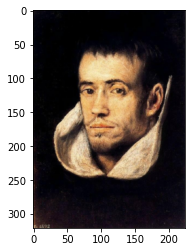

[('spanish', 38.12519836425781)]

In [63]:
predict_img("spanish.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


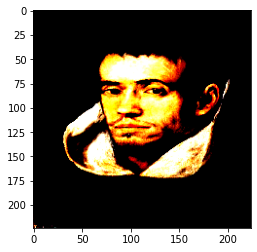

soft tensor([[5.0527e-02, 1.2649e-01, 6.1761e-01, 1.9385e-01, 3.8131e-06, 1.2910e-05,
         8.5541e-06, 1.7563e-05, 1.3322e-05, 2.8553e-06, 1.7871e-06, 2.9754e-06,
         2.5591e-06, 2.7259e-06, 8.5485e-06, 7.2830e-06, 2.5807e-06, 1.5962e-05,
         1.2857e-05, 5.0465e-06, 1.3188e-06, 2.7316e-06, 2.3188e-06, 6.9971e-06,
         6.1780e-06, 3.8512e-06, 5.3297e-06, 2.8289e-06, 7.0491e-06, 3.3377e-06,
         6.2770e-06, 6.1825e-06, 6.2042e-06, 9.0205e-06, 8.6864e-06, 1.2109e-05,
         4.1842e-05, 5.7026e-06, 2.4006e-05, 1.7745e-05, 1.2544e-05, 5.1370e-06,
         4.1743e-06, 1.8325e-06, 4.2381e-06, 4.0410e-06, 1.0975e-05, 2.6894e-06,
         9.6605e-07, 1.3096e-06, 1.1872e-05, 1.3842e-06, 3.8824e-06, 2.8453e-06,
         2.7289e-06, 2.8387e-06, 5.0677e-06, 9.6746e-07, 5.1302e-06, 5.1646e-06,
         1.0634e-05, 6.3523e-06, 6.5301e-06, 5.5484e-06, 5.2057e-06, 5.1565e-06,
         1.4602e-06, 3.0569e-06, 9.1251e-07, 2.0345e-06, 1.4988e-06, 7.4616e-06,
         6.2385e-06, 6.

('Predicted :', 'japanese')

In [61]:
predict_image_class_name('spanish.jpg',model) 